In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
##session = 'ALTAI_20240807_SESSION_00'
#path = '/Volumes/data2/eTheremin/ALTAI/'+ session + '/'

In [2]:
from functions_get_data import *
import numpy as np
from utils_extraction import get_session_type_final
from utils_tt import *

In [71]:
import pickle
path = '/auto/data6/eTheremin/MMELOIK/MMELOIK_20241126_SESSION_01/headstage_1/'


In [74]:
pkl_path = path+'tt.pkl'

with open(pkl_path, 'rb') as file:
    triggers_data = pickle.load(file)
an_times =  triggers_data['triggers']

In [75]:
triggers_data

{'tones': array([2000., 2317., 2684., ..., 2684., 2317., 2000.]),
 'triggers': [125079,
  179439,
  331839,
  334839,
  359798,
  359958,
  393158,
  414758,
  443078,
  445478,
  445638,
  455438,
  471158,
  473238,
  473438,
  473598,
  474318,
  474558,
  474918,
  476598,
  477158,
  477758,
  499118,
  502478,
  502838,
  507318,
  512078,
  524238,
  525558,
  542238,
  565278,
  566438,
  567398,
  567758,
  567918,
  568278,
  568638,
  568878,
  571638,
  572078,
  572958,
  574118,
  574478,
  574838,
  636918,
  647078,
  647238,
  647798,
  648158,
  652118,
  690558,
  690918,
  691118,
  717158,
  717398,
  717558,
  728798,
  729158,
  730118,
  749798,
  904877,
  954917,
  960197,
  964117,
  976477,
  1003477,
  1005917,
  1006277,
  1007237,
  1007797,
  1009637,
  1009877,
  1351876,
  1385436,
  1402276,
  1412236,
  1424436,
  1440396,
  1458916,
  1471476,
  1486516,
  1532436,
  1552116,
  1567876,
  1580596,
  1588276,
  1596036,
  1602756,
  1618276,
  162691

In [50]:
spk = np.load('/auto/data6/eTheremin/MMELOIK/MMELOIK_20241126_SESSION_00/headstage_1/spike_times.npy')

In [52]:
sc  =np.load('/auto/data6/eTheremin/MMELOIK/MMELOIK_20241126_SESSION_00/headstage_1/spike_clusters.npy')

In [54]:
neural = np.load('/auto/data6/eTheremin/MMELOIK/MMELOIK_20241126_SESSION_00/headstage_1/neural_data.npy')

In [5]:
t_pre = 0.5#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
session = 'ALTAI_20240822_SESSION_00'
path = '/auto/data2/eTheremin/ALTAI/'+ session + '/'

In [6]:
triggers_tr, tones_total_tr = get_triggers(path+'headstage_0/', analog_line=0)
triggers_pb, tones_total_pb = get_triggers(path+'headstage_0/', analog_line=1)
triggers_mck, tones_total_mck = get_triggers(path+'headstage_0/', analog_line=3)
        
condition_tr = np.zeros(len(triggers_tr))
condition_pb = np.ones(len(triggers_pb)) 
            
trig_times = np.concatenate((triggers_tr, triggers_pb)) 
tones = np.concatenate((tones_total_tr, tones_total_pb))
condition = np.concatenate((condition_tr, condition_pb))
            

In [7]:
sorted_indices = np.argsort(trig_times[:len(tones)])
sorted_indices = sorted_indices[:-1]
sorted_triggers = trig_times[sorted_indices]
sorted_tones = tones[sorted_indices]
sorted_condition = condition[sorted_indices]

In [9]:
diff = np.diff(sorted_condition)

# Indices de passage de 0 à 1 (diff = 1)
tr_to_pb = np.where(diff == 1)[0]  # Indices avant la transition

# Indices de passage de 1 à 0 (diff = -1)
pb_to_tr = np.where(diff == -1)[0]  # Indices avant la transition

print("Indices où on passe de 0 à 1 :", tr_to_pb)
print("Indices où on passe de 1 à 0 :", pb_to_tr)

Indices où on passe de 0 à 1 : [1633 3111 4449 5899 7560 9230]
Indices où on passe de 1 à 0 : [ 2303  3919  4979  6818  8301 10158]


In [23]:
for i in range(1, 5):
    debut_pb = tr_to_pb[i]
    debut_tr = pb_to_tr[i]
    print(debut_pb, debut_tr)
  
    # Utiliser cet indice pour trouver l'élément correspondant dans `triggers`
    first_tr = sorted_triggers[debut_pb] # triggers du tracking pour le block i
    first_tone = sorted_tones[debut_pb]

    second_tr = sorted_triggers[debut_tr] # triggers du playback pour le block i
    second_tone = sorted_tones[debut_tr]
    longueur = (second_tr - first_tr)/(30000*60)

    print(f'Durée du playback selon tt pour le block {i}: ', longueur)

3111 3919
Durée du playback selon tt pour le block 1:  5.000086111111111
4449 4979
Durée du playback selon tt pour le block 2:  4.999887222222222
5899 6818
Durée du playback selon tt pour le block 3:  4.999977222222222
7560 8301
Durée du playback selon tt pour le block 4:  4.9999561111111115


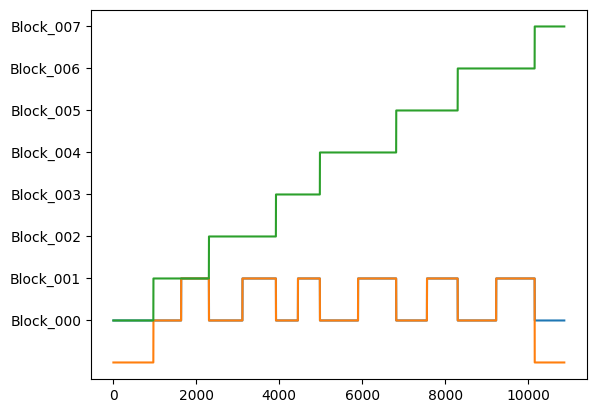

In [ ]:
plt.plot(sorted_condition)
plt.plot(condition)
plt.plot(block)
print()

In [41]:
# Calcul des différences entre éléments consécutifs
diff = np.diff(block)

# Trouver les indices où il y a un changement (différent de 0)
change_indices = np.where(diff != 0)[0]

# Les indices de changement concernent les transitions, donc pour obtenir les indices **après le changement**
change_indices_after = change_indices + 1

print("Indices de changement (avant transition) :", change_indices)
print("Indices de changement (après transition) :", change_indices_after)

Indices de changement (avant transition) : [  963  2302  3918  4978  6818  8301 10157]
Indices de changement (après transition) : [  964  2303  3919  4979  6819  8302 10158]


In [42]:
print(sorted_triggers[change_indices]/fs)
print(sorted_triggers[change_indices_after]/fs)
print(np.diff(sorted_triggers[change_indices]/(fs*60)))

[ 304.44016667  885.38876667 1503.59763333 2100.17073333 2704.25596667
 3304.20266667 3903.30673333]
[ 304.49083333  885.45676667 1503.6283     2100.59606667 2704.53596667
 3304.552      3903.42006667]
[ 9.68247667 10.30348111  9.942885   10.06808722  9.99911167  9.98506778]


In [43]:
# Calcul des différences entre éléments consécutifs
diff = np.diff(condition)

# Trouver les indices où il y a un changement (différent de 0)
change_indices = np.where(diff != 0)[0]

# Les indices de changement concernent les transitions, donc pour obtenir les indices **après le changement**
change_indices_after = change_indices + 1

print("Indices de changement (avant transition) :", change_indices)
print("Indices de changement (après transition) :", change_indices_after)
print("fréquences avant : ", tones[change_indices])
print("fréquences après : ",tones[change_indices_after])

Indices de changement (avant transition) : [  963  1632  2302  3110  3918  4448  4978  5898  6818  7560  8301  9229
 10157]
Indices de changement (après transition) : [  964  1633  2303  3111  3919  4449  4979  5899  6819  7561  8302  9230
 10158]
fréquences avant :  [3109.  533.  533.  828.  828.  533.  533. 3601. 3601.  828.  828.  397.
  397.]
fréquences après :  [3601. 3109. 2684. 2684. 6484. 6484. 3601. 3601.  828. 2000.  533.  533.
  533.]


In [28]:
json_path = find_json(path)
extracted_data = read_json_file(json_path)
tones, labels, mock_tones = concatenate_tones_and_labels(extracted_data, path+'headstage_0/tones')
condition, block = convert_condition_block(tones, labels)

block = np.array([b.split('_')[-1] for b in block], dtype = int)

TrackingTail
TrackingTail
tail length =  964
670 669
808 808
530 530
920 920
741 742
928 928
tail length =  716
928 928


['Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Block_000',
 'Bloc

In [18]:
print(len(condition))
print(len(sorted_condition))

10874
10874


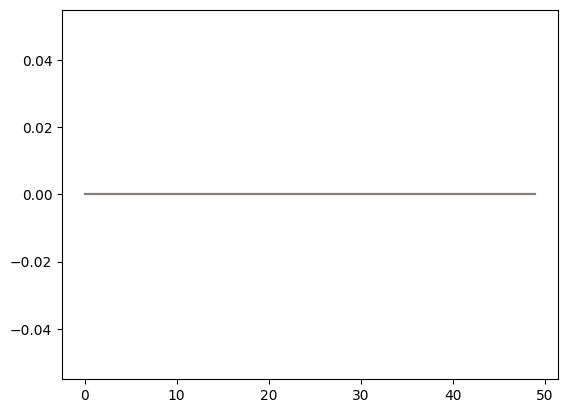

In [22]:
plt.plot(condition[5000:5050], c = 'red')
plt.plot(sorted_condition[5000:5050], c = 'grey')

In [13]:
import pickle

# Path to your .pkl file
file_path = path+"headstage_0/tt.pkl"

# Load the pickle file
with open(file_path, "rb") as file:
    tt = pickle.load(file)

In [14]:
print(len(tt['mock_tones']), len(tt['mock_triggers']))

2414 2414


In [46]:
print(len(tt['tones']), len(tt['triggers']))

11523 11517


In [52]:
triggers_tr, tones_total_tr = get_triggers(path+'headstage_0/', analog_line=3)

In [53]:
print(len(triggers_tr), len(tones_total_tr))

3522 3522


In [58]:
mock_tones = np.concatenate([element for sous_tableau in tones_total_tr for element in sous_tableau])

TypeError: 'numpy.float64' object is not iterable

In [5]:
create_tt_no_mock(path, mock=True)

OSError: [Errno 9] Bad file descriptor

In [8]:
an = np.load( '/Volumes/data2/eTheremin/ALTAI/'+ session + '/analog_in.npy')

KeyboardInterrupt: 

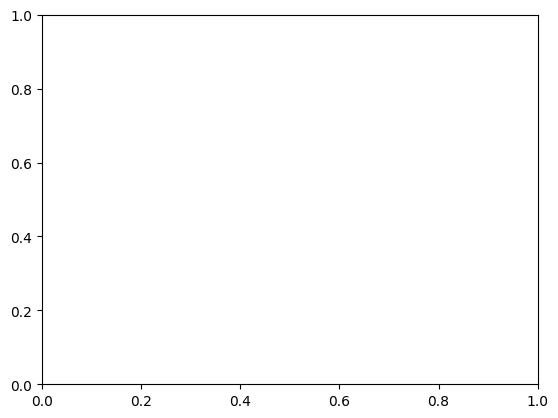

In [11]:
plt.plot(an[2])

In [7]:
triggers_tr, tones_total_tr = get_triggers(path+'headstage_0/', analog_line=0)

OSError: [Errno 9] Bad file descriptor

In [ ]:
import pickle

# Path to your .pkl file
file_path = "headstage_0/tt.pkl"

# Load the pickle file
with open(file_path, "rb") as file:
    tt = pickle.load(file)

In [124]:
session = 'MMELOIK_20241025/MMELOIK_20241025_SESSION_00'
path = '/Volumes/data6/eTheremin/MMELOIK/'+ session + '/'

In [127]:
triggers_tr, tones_total_tr = get_triggers(path+'headstage_0/', analog_line=0)
triggers_pb, tones_total_pb = get_triggers(path+'headstage_0/', analog_line=1)
        

In [129]:
triggers_pb

array([], dtype=int64)

In [110]:

# Chemin du fichier .pkl
tt_path = path + 'headstage_0/tt.pkl'

# Ouvrir et charger le fichier .pkl
with open(tt_path, 'rb') as file:  # 'rb' signifie read-binary (lecture en binaire)
    tt = pickle.load(file)

spk_times = np.load(path + 'headstage_0/spike_times.npy')
spk_clusters = np.load(path + 'headstage_0/spike_clusters.npy')


In [111]:
import numpy as np

def compute_psth(spike_times, stimulus_times, bin_size, window, sr):
    """
    Calculate independent PSTHs for each stimulus time.

    Parameters:
    - spike_times: Array of spike times in seconds.
    - stimulus_times: Array of stimulus times in seconds.
    - bin_size: Size of the bins for the histogram.
    - window: Time window around the stimulus to consider (tuple of (start, end)).
    - sr: Sampling rate for converting times if needed.

    Returns:
    - psth_list: List of PSTHs for each stimulus.
    - bin_edges: The edges of the bins used.
    """
    # Convert stimulus and spike times to seconds if not already
    if np.issubdtype(type(stimulus_times), np.number):
        stimulus_times = stimulus_times / sr  # if stimulus_times is an array of numbers
    else:
        stimulus_times = np.array([x / sr for x in stimulus_times])  # if stimulus_times is a list

    spike_times = spike_times / sr  # Convert spike times to seconds
    psth_list = []
    
    # For each stimulus, compute the PSTH independently
    for stim_time in stimulus_times:
        # Get spikes relative to the current stimulus time
        relative_spikes = spike_times - stim_time
        # Select spikes that fall within the specified window
        selected_spikes = relative_spikes[(relative_spikes >= window[0]) & (relative_spikes <= window[1])]
        
        # Create histogram for selected spikes
        bins = np.arange(window[0], window[1] + bin_size, bin_size)
        hist, bin_edges = np.histogram(selected_spikes, bins=bins)
        
        # Store the histogram as a PSTH
        psth_list.append(hist)
    
    return psth_list, bin_edges


In [117]:

an_times = np.array(tt['triggers'])
tones = np.array(tt['tones'])
conditions = np.array(tt['condition'])
sr = 30000
#PLOT
t_pre = 0.3#
t_post = 0.50#0.300
bin_width = 0.05
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
window = [-t_pre, t_post]


clusters = {}
for value, cluster in zip(spk_times, spk_clusters):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(value)
for cluster, values in clusters.items():
    print(f"Cluster {cluster}: {len(values)}")


tracking, playback = [], []

tracking_stim_times = an_times[conditions == 0]
playback_stim_times = an_times[conditions == 1]
    #
for cluster in range(32):
    spike_times = np.array(clusters[cluster])
    tr_psth,tr_edges = compute_psth(spike_times, tracking_stim_times, bin_width, window, sr)
    tracking.append(tr_psth)

    pb_psth,pb_edges = compute_psth(spike_times, playback_stim_times, bin_width, window, sr)
    playback.append(pb_psth)

Cluster 4: 162141
Cluster 22: 133470
Cluster 15: 228086
Cluster 0: 297546
Cluster 5: 378279
Cluster 12: 111460
Cluster 31: 230267
Cluster 27: 120673
Cluster 30: 117073
Cluster 10: 129764
Cluster 7: 156072
Cluster 9: 163484
Cluster 1: 221479
Cluster 8: 366741
Cluster 2: 252795
Cluster 16: 216581
Cluster 20: 265854
Cluster 19: 204386
Cluster 21: 411305
Cluster 13: 176630
Cluster 25: 305326
Cluster 26: 360264
Cluster 3: 475983
Cluster 28: 232983
Cluster 24: 282482
Cluster 23: 216071
Cluster 11: 125569
Cluster 14: 263970
Cluster 6: 120913
Cluster 18: 118373
Cluster 17: 162367
Cluster 29: 176251


In [118]:
tracking_transpose = np.moveaxis(tracking, 1, 0)     # ici matrice transposée dans le bon format  : n_trigs x n_clus x n_bins
playback_transpose = np.moveaxis(playback, 1, 0) 
X_total = np.vstack((tracking_transpose, playback_transpose)) # tracking et playback concaténés

y_tracking = np.zeros(len(tracking_transpose))
y_playback = np.ones(len(playback_transpose))
y = np.hstack((y_tracking,y_playback ))

In [119]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy_total = []
for k in range(len(psth_bins)):
    X = X_total[:, :, k]


    # Étape 3: Séparer les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Étape 4: Standardiser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Étape 5: Entraîner un modèle (Random Forest dans cet exemple)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Étape 6: Faire des prédictions
    y_pred = model.predict(X_test_scaled)

    # Étape 7: Évaluer le modèle
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_total.append(accuracy)
    print("Exactitude (accuracy):", accuracy)

Exactitude (accuracy): 0.6802610114192496
Exactitude (accuracy): 0.6829798803697662
Exactitude (accuracy): 0.6851549755301795
Exactitude (accuracy): 0.6797172376291463
Exactitude (accuracy): 0.6829798803697662
Exactitude (accuracy): 0.6715606307775965
Exactitude (accuracy): 0.679173463839043
Exactitude (accuracy): 0.680804785209353
Exactitude (accuracy): 0.6938553561718325
Exactitude (accuracy): 0.6840674279499728
Exactitude (accuracy): 0.6699293094072866
Exactitude (accuracy): 0.6851549755301795
Exactitude (accuracy): 0.6731919521479065
Exactitude (accuracy): 0.6802610114192496
Exactitude (accuracy): 0.687873844480696
Exactitude (accuracy): 0.677542142468733


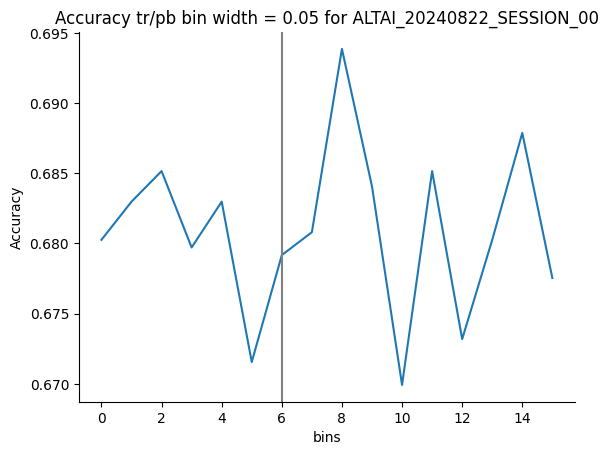

In [120]:
plt.plot(accuracy_total)
plt.axvline(t_pre/bin_width, c='grey')
plt.title(f'Accuracy tr/pb bin width = {bin_width} for {session}')
plt.xlabel('bins')
plt.ylabel('Accuracy')

# Retirer les bordures droite et haute
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


In [121]:
import numpy as np

def compute_psth_tones(spike_times, stimulus_times, tones, bin_size, window, sr):
    """
    Calculate independent PSTHs for each stimulus time, including associated tones.

    Parameters:
    - spike_times: Array of spike times in seconds.
    - stimulus_times: Array of stimulus times in seconds.
    - tones: Array of tones associated with each stimulus time.
    - bin_size: Size of the bins for the histogram.
    - window: Time window around the stimulus to consider (tuple of (start, end)).
    - sr: Sampling rate for converting times if needed.

    Returns:
    - psth_list: List of PSTHs for each stimulus.
    - bin_edges: The edges of the bins used.
    - tone_list: List of tones associated with each PSTH.
    - trigger_times: List of trigger times associated with each PSTH.
    """
    # Convert stimulus and spike times to seconds if not already
    if np.issubdtype(type(stimulus_times), np.number):
        stimulus_times = stimulus_times / sr  # if stimulus_times is an array of numbers
    else:
        stimulus_times = np.array([x / sr for x in stimulus_times])  # if stimulus_times is a list

    spike_times = spike_times / sr  # Convert spike times to seconds
    psth_list = []
    tone_list = []  # To store associated tones
    trigger_times = []  # To store corresponding trigger times
    
    # For each stimulus, compute the PSTH independently
    for i, stim_time in enumerate(stimulus_times):
        # Get spikes relative to the current stimulus time
        relative_spikes = spike_times - stim_time
        # Select spikes that fall within the specified window
        selected_spikes = relative_spikes[(relative_spikes >= window[0]) & (relative_spikes <= window[1])]
        
        # Create histogram for selected spikes
        bins = np.arange(window[0], window[1] + bin_size, bin_size)
        hist, bin_edges = np.histogram(selected_spikes, bins=bins)
        
        # Store the histogram as a PSTH
        psth_list.append(hist)
        tone_list.append(tones[i])  # Store the associated tone
        trigger_times.append(stim_time)  # Store the corresponding trigger time
    
    return psth_list, bin_edges, tone_list, trigger_times
